# Load dependencies and tables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Markdown as md
from collections import Counter

In [3]:
output_tables = "output_tables"
run_dir_name = "2024_11_18_16_07_output"
run_dir = os.path.join(output_tables, run_dir_name)

df_sample_mapping = pd.read_csv(os.path.join(output_tables, "sample_mapping.csv"))

df_filter_mapping_full = pd.read_csv(os.path.join(run_dir, "filter_mapping_full.csv"))
df_filter_mapping = pd.read_csv(os.path.join(run_dir, "filter_mapping.csv"))
df_truncate_mapping = pd.read_csv(os.path.join(run_dir, "truncate_mapping.csv"))

df_refseq_full = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_full.csv"))
df_refseq = pd.read_csv(os.path.join(run_dir, "refseq_table_pk.csv"))

df_refseq_srr_mapping_full = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr_full.csv"))
df_refseq_srr_mapping = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr.csv"))

df_refseq_tax_full = pd.read_csv(os.path.join(run_dir, "tax_refseq_table_pk_full.csv"))
df_refseq_tax = pd.read_csv(os.path.join(run_dir, "tax_refseq_table_pk.csv"))

df_phylo_blast_full = pd.read_csv(os.path.join(run_dir, "phylo_blast_refseq_table_pk_full.csv"))
df_phylo_blast = pd.read_csv(os.path.join(run_dir, "phylo_blast_refseq_table_pk.csv"))

latex_tables = "latex_tables"
os.makedirs(latex_tables, exist_ok=True)

In [104]:
# plotting globals
xlim_low, xlim_high = 200, 450
bin_space = 10
bins = [xlim_low + i*bin_space for i in range(int((xlim_high-xlim_low)/bin_space))]

In [105]:
# Merged table for analyzing results
df = df_sample_mapping.merge(df_truncate_mapping, on=["srr_name"], how="right")
df = df.merge(df_filter_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_filter_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}), on=["srr_name", "trunc_zotu_id"],
              suffixes=("_full", "_trunc"), how="left")
df = df.merge(df_refseq_srr_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_refseq_srr_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}),
                                                        on=["srr_name", "trunc_zotu_id"], suffixes=("_full", "_trunc"), how="left")

df_refseq_tax_merged = df_refseq.merge(df_refseq_tax, on=["refsequence_pk"], how="left", indicator=True)
df_refseq_tax_merged["tax_missing"] = df_refseq_tax_merged["UNITE_id"].isna()
df_refseq_tax_merged = df_refseq_tax_merged.drop(columns=["_merge"])

df_refseq_tax_merged_full = df_refseq_full.merge(df_refseq_tax_full, on=["refsequence_pk"], how="left", indicator=True)
df_refseq_tax_merged_full["tax_missing"] = df_refseq_tax_merged_full["UNITE_id"].isna()
df_refseq_tax_merged_full = df_refseq_tax_merged_full.drop(columns=["_merge"])

df = df.merge(df_refseq_tax_merged_full.rename(
    columns={"refsequence_pk": "refsequence_pk_full", "sequence": "sequence_full"}),
    on=["refsequence_pk_full", "sequence_full"], how="left")
df = df.merge(df_refseq_tax_merged.rename(
    columns={"refsequence_pk": "refsequence_pk_trunc", "sequence": "sequence_trunc"}),
    on=["refsequence_pk_trunc", "sequence_trunc"], suffixes=("_full", "_trunc"), how="left")

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65595 entries, 0 to 65594
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   srr_name              65595 non-null  object 
 1   plot                  65595 non-null  object 
 2   subplot               65588 non-null  float64
 3   location              65595 non-null  object 
 4   zotu_id               65595 non-null  object 
 5   trunc_zotu_id         64279 non-null  object 
 6   passed_trunc          65595 non-null  bool   
 7   passed_abun_full      65595 non-null  bool   
 8   passed_contam_full    65595 non-null  bool   
 9   passed_abun_trunc     64279 non-null  object 
 10  passed_contam_trunc   64279 non-null  object 
 11  refsequence_pk_full   6033 non-null   object 
 12  sequence_full         6033 non-null   object 
 13  refsequence_pk_trunc  6532 non-null   object 
 14  sequence_trunc        6532 non-null   object 
 15  marker_type_full   

None

# Filter results within samples

In [106]:
#Filter results on full length ZOTUs
df_filter_counts = pd.DataFrame.join(
    df.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True).round(4))
df_filter_counts.loc[(True,""),:] = df_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
df_filter_counts["count"] = df_filter_counts["count"].astype(int)

display(md("## Filter results on full length ZOTUs"))
display(md(f"Of all {df.shape[0]} full length ZOTUs found across all samples:"))
display(df_filter_counts)

num_passed_abun = df_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter"))

df_filter_counts.to_latex(os.path.join(latex_tables, "filter_results_full.tex"), escape=True)

## Filter results on full length ZOTUs

Of all 65595 full length ZOTUs found across all samples:

count  proportion
passed_abun_full passed_contam_full                   
False            False               59470      0.9066
True             True                 6033      0.0920
                 False                  92      0.0014
                                      6125      0.0934

- 6125.0 (9.34%) passed the abundance filter
- 6033.0 (9.20% of all, 98.50% of abundant) passed the contamination filter

In [107]:
# Truncation results on full length ZOTUs
df_trunc = df[df["passed_trunc"] == True]
df_trunc_derep = df_trunc.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])
df_trunc_counts = pd.DataFrame.join(
    df.value_counts(subset="passed_trunc"),
    df.value_counts(subset="passed_trunc", normalize=True).round(4))
df_trunc_counts = df_trunc_counts.join(
    df_trunc_derep.value_counts(subset="passed_trunc"), rsuffix=" derep")
df_trunc_counts["count derep"] = df_trunc_counts["count derep"].astype('Int64')
display(md("## Truncation results on full length ZOTUs"))
display(md(f"Of all {df.shape[0]} full length ZOTUs found across all samples:"))
display(df_trunc_counts)

num_passed_trunc = df_trunc_counts.loc[True]['count']
prop_passed_trunc = df_trunc_counts.loc[True]['proportion']
num_not_passed_trunc = df_trunc_counts.loc[False]['count']
prop_not_passed_trunc = df_trunc_counts.loc[False]['proportion']
display(md(f"- {num_passed_trunc} ({prop_passed_trunc:.2%}) passed truncation\n"
           f"\t- {df_trunc_counts.loc[True]['count derep']} after dereplication within samples\n"
           f"- {num_not_passed_trunc} ({prop_not_passed_trunc:.2%}) did not pass truncation (<250bp) and are discarded"))

df_trunc_counts.to_latex(os.path.join(latex_tables, "trunc_results.tex"), escape=True)

## Truncation results on full length ZOTUs

Of all 65595 full length ZOTUs found across all samples:

,count,proportion,count derep
passed_trunc,,,
True,64279,0.9799,61373
False,1316,0.0201,<NA>


- 64279.0 (97.99%) passed truncation
	- 61373.0 after dereplication within samples
- 1316.0 (2.01%) did not pass truncation (<250bp) and are discarded

In [108]:
# Filter results on discarded ZOTUs
df_discard = df[df["passed_trunc"] == False]
df_discard_filter_counts = pd.DataFrame.join(
    df_discard.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df_discard.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True).round(4))
df_discard_filter_counts.loc[(True,""),:] = df_discard_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
df_discard_filter_counts["count"] = df_discard_filter_counts["count"].astype(int)
display(md("## Filter results on discarded ZOTUs"))
display(md(f"Of the {df_discard.shape[0]} full length ZOTUs that do not pass truncation (<250bp):"))
display(df_discard_filter_counts)

num_passed_abun = df_discard_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_discard_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_discard_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_discard_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) would have passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) would have passed the contamination filter"))

df_discard_filter_counts.to_latex(os.path.join(latex_tables, "discard_filter_results.tex"), escape=True)

## Filter results on discarded ZOTUs

Of the 1316 full length ZOTUs that do not pass truncation (<250bp):

count  proportion
passed_abun_full passed_contam_full                   
False            False                1254      0.9529
True             True                   47      0.0357
                 False                  15      0.0114
                                        62      0.0471

- 62.0 (4.71%) would have passed the abundance filter
- 47.0 (3.57% of all, 75.80% of abundant) would have passed the contamination filter

In [109]:
# Filter results on truncated ZOTUs
df_trunc_filter_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True).round(4))
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']), rsuffix=" derep")
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True).round(4), rsuffix=" derep")
df_trunc_filter_counts.loc[(True,""),:] = df_trunc_filter_counts.loc[(True, slice(None))][['count', 'proportion', 'count derep', 'proportion derep']].sum()
df_trunc_filter_counts["count"] = df_trunc_filter_counts["count"].astype(int)
df_trunc_filter_counts["count derep"] = df_trunc_filter_counts["count derep"].astype(int)

display(md("## Filter results on truncated ZOTUs"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_trunc_filter_counts)

num_passed_abun = df_trunc_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_trunc_filter_counts.loc[(True, '')]['proportion']
num_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['count derep']
prop_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['proportion derep']
num_passed_contam = df_trunc_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_trunc_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
num_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['count derep']
prop_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['proportion derep']
prop_passed_contam_abun_derep = prop_passed_contam_derep / prop_passed_abun_derep
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"\t- {num_passed_abun_derep} ({prop_passed_abun_derep:.2%}) after dereplication within samples\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter\n"
           f"\t- {num_passed_contam_derep} ({prop_passed_contam_derep:.2%} of all, {prop_passed_contam_abun_derep:.2%} of abundant) after dereplication within samples"))

df_trunc_filter_counts.to_latex(os.path.join(latex_tables, "filter_results_trunc.tex"), escape=True)

## Filter results on truncated ZOTUs

Of all 64279 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

count  proportion  count derep  \
passed_abun_trunc passed_contam_trunc                                   
False             False                57652      0.8969        55247   
True              True                  6532      0.1016         6051   
                  False                   95      0.0015           75   
                                        6627      0.1031         6126   

                                       proportion derep  
passed_abun_trunc passed_contam_trunc                    
False             False                          0.9002  
True              True                           0.0986  
                  False                          0.0012  
                                                 0.0998

- 6627.0 (10.31%) passed the abundance filter
	- 6126.0 (9.98%) after dereplication within samples
- 6532.0 (10.16% of all, 98.55% of abundant) passed the contamination filter
	- 6051.0 (9.86% of all, 98.80% of abundant) after dereplication within samples

In [110]:
# Comparing filter results before and after truncation
df_abun_compare_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc'], normalize=True).round(4))
df_abun_compare_counts.loc[(True,True,"",""),:] = df_abun_compare_counts.loc[(True, True, slice(None), slice(None))][['count', 'proportion']].sum()
df_abun_compare_counts.loc[(False,True,"",""),:] = df_abun_compare_counts.loc[(False, True, slice(None), slice(None))][['count', 'proportion']].sum()
df_abun_compare_counts["count"] = df_abun_compare_counts["count"].astype(int)
df_abun_compare_counts = df_abun_compare_counts.sort_index(level="passed_abun_full", sort_remaining=False)

df_trunc_abun_both = df_trunc[(df_trunc['passed_abun_full'] == True) & (df_trunc['passed_abun_trunc'] == True)]
df_trunc_abun_both_derep = df_trunc_abun_both.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])

df_trunc_abun_trunc_only = df_trunc[(df_trunc['passed_abun_full'] == False) & (df_trunc['passed_abun_trunc'] == True)]
df_trunc_abun_trunc_only = df_trunc_abun_trunc_only.merge(
    df_trunc_abun_both_derep[['srr_name', 'trunc_zotu_id']], how='left', indicator=True).set_index(df_trunc_abun_trunc_only.index)
df_trunc_abun_trunc_only['new_zotu_trunc'] = df_trunc_abun_trunc_only['_merge'] == 'left_only'
df_trunc_abun_trunc_only = df_trunc_abun_trunc_only.drop(columns=['_merge'])
df_trunc_abun_trunc_only_derep = df_trunc_abun_trunc_only.drop_duplicates(subset=["srr_name", "trunc_zotu_id"])

df_trunc_contam_both = df_trunc_abun_both[(df_trunc_abun_both['passed_contam_full'] == True) & (df_trunc_abun_both['passed_contam_trunc'] == True)]
df_trunc_contam_both_derep = df_trunc_contam_both.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])

df_trunc_contam_trunc_only = df_trunc_abun_trunc_only[df_trunc_abun_trunc_only['passed_contam_trunc'] == True]
df_trunc_contam_trunc_only_derep = df_trunc_contam_trunc_only.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])

display(md("## Comparing filter results before and after truncation"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_abun_compare_counts)
display(md(f"- {df_trunc_abun_both.shape[0]} passed the abundance filter both at full length and truncated\n"
           f"\t- mapping to {df_trunc_abun_both_derep.shape[0]} dereplicated truncated ZOTUs\n"
           f"- {df_trunc_contam_both.shape[0]} passed the contamination filter both at full length and truncated\n"
           f"\t- mapping to {df_trunc_contam_both_derep.shape[0]} dereplicated truncated ZOTUs\n"
           f"- {df_trunc_abun_trunc_only.shape[0]} passed the abundance filter only when truncated\n"
           f"\t- mapping to {df_trunc_abun_trunc_only_derep.shape[0]} dereplicated truncated ZOTUs\n"
           f"- {df_trunc_contam_trunc_only.shape[0]} passed the contamination filter only when truncated\n"
           f"\t- mapping to {df_trunc_contam_trunc_only_derep.shape[0]} dereplicated truncated ZOTUs\n"
           "- None no longer pass the contamination filter after truncation when they would have passed at full length"))

df_abun_compare_counts.to_latex(os.path.join(latex_tables, "filter_comp.tex"), escape=True)

df_trunc_abun_trunc_only_counts = pd.DataFrame.join(
    df_trunc_abun_trunc_only.value_counts(subset=['new_zotu_trunc', 'passed_contam_trunc']),
    df_trunc_abun_trunc_only_derep.value_counts(subset=['new_zotu_trunc', 'passed_contam_trunc']), rsuffix=" derep")
df_trunc_abun_trunc_only_counts.loc[(True,""),:] = df_trunc_abun_trunc_only_counts.loc[(True, slice(None))][['count', 'count derep']].sum()
df_trunc_abun_trunc_only_counts = df_trunc_abun_trunc_only_counts.astype(int)
df_trunc_abun_trunc_only_counts = df_trunc_abun_trunc_only_counts.sort_index(level="new_zotu_trunc", sort_remaining=False)

df_trunc_abun_trunc_only_new = df_trunc_abun_trunc_only[df_trunc_abun_trunc_only['new_zotu_trunc'] == True]
df_trunc_abun_trunc_only_derep_new = df_trunc_abun_trunc_only_derep[df_trunc_abun_trunc_only_derep['new_zotu_trunc'] == True]

df_trunc_contam_trunc_only_new = df_trunc_contam_trunc_only[df_trunc_contam_trunc_only['new_zotu_trunc'] == True]
df_trunc_contam_trunc_only_derep_new = df_trunc_contam_trunc_only_derep[df_trunc_contam_trunc_only_derep['new_zotu_trunc'] == True]

display(md(f"Of the {df_trunc_abun_trunc_only.shape[0]} truncated ZOTUs that passed the abundance filter only when truncated:"))
display(df_trunc_abun_trunc_only_counts)
display(md(f"- {df_trunc_abun_trunc_only_new.shape[0]} are \"new\", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length\n"
           f"\t- {df_trunc_abun_trunc_only_derep_new.shape[0]} after dereplication within samples\n"
           f"- {df_trunc_contam_trunc_only_new.shape[0]} are \"new\" and also pass the contamination filter\n"
           f"\t- {df_trunc_contam_trunc_only_derep_new.shape[0]} after dereplication within samples"))

df_trunc_abun_trunc_only_counts.to_latex(os.path.join(latex_tables, "filter_trunc_only.tex"), escape=True)


## Comparing filter results before and after truncation

Of all 64279 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

count  \
passed_abun_full passed_abun_trunc passed_contam_full passed_contam_trunc          
False            False             False              False                57652   
                 True              False              True                   546   
                                                      False                   18   
                                                                             564   
True             True              True               True                  5986   
                                   False              False                   77   
                                                                            6063   

                                                                           proportion  
passed_abun_full passed_abun_trunc passed_contam_full passed_contam_trunc              
False            False             False              False                    0.8969  
                 True              False              True                     0.0085  
                                                      False                    0.0003  
                                                                               0.0088  
True             True              True               True                     0.0931  
                                   False              False                    0.0012  
                                                                               0.0943

- 6063 passed the abundance filter both at full length and truncated
	- mapping to 5995 dereplicated truncated ZOTUs
- 5986 passed the contamination filter both at full length and truncated
	- mapping to 5922 dereplicated truncated ZOTUs
- 564 passed the abundance filter only when truncated
	- mapping to 393 dereplicated truncated ZOTUs
- 546 passed the contamination filter only when truncated
	- mapping to 381 dereplicated truncated ZOTUs
- None no longer pass the contamination filter after truncation when they would have passed at full length

Of the 564 truncated ZOTUs that passed the abundance filter only when truncated:

count  count derep
new_zotu_trunc passed_contam_trunc                    
False          True                   317          252
               False                   14           10
True           True                   229          129
               False                    4            2
                                      233          131

- 233 are "new", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length
	- 131 after dereplication within samples
- 229 are "new" and also pass the contamination filter
	- 129 after dereplication within samples

# Positive control results

In [111]:
#Extract positive control ZOTUs

df_pc = df[df["plot"] == "PC"]
display(df_pc[["identity_full", "UNITE_id_full", "identity_trunc", "UNITE_id_trunc", "species_trunc"]])
df = df.drop(df_pc.index)

,identity_full,UNITE_id_full,identity_trunc,UNITE_id_trunc,species_trunc
47372,99.7,SH0854870.10FU,100.0,SH0854870.10FU,s__Lactarius_aurantiolamellatus
47373,NaN,NaN,NaN,NaN,NaN
47374,NaN,NaN,NaN,NaN,NaN
47375,NaN,NaN,NaN,NaN,NaN
47376,NaN,NaN,NaN,NaN,NaN
47377,NaN,NaN,NaN,NaN,NaN
47378,NaN,NaN,NaN,NaN,NaN


# Reference table results

In [124]:
#Comparing reference sequences before and after truncation

df_refseq_both = df[(df["passed_contam_full"]) | (df["passed_contam_trunc"])].drop_duplicates(
    subset=["location", "refsequence_pk_full", "refsequence_pk_trunc"])
df_refseq_both["refseq_full_exclusive_to_loc"] = ~(
    df_refseq_both["refsequence_pk_full"].isin(df_refseq_both[df_refseq_both["location"] == "A"]["refsequence_pk_full"]) &
    df_refseq_both["refsequence_pk_full"].isin(df_refseq_both[df_refseq_both["location"] == "B"]["refsequence_pk_full"]
))
df_refseq_both["refseq_trunc_exclusive_to_loc"] = ~(
    df_refseq_both["refsequence_pk_trunc"].isin(df_refseq_both[df_refseq_both["location"] == "A"]["refsequence_pk_trunc"]) &
    df_refseq_both["refsequence_pk_trunc"].isin(df_refseq_both[df_refseq_both["location"] == "B"]["refsequence_pk_trunc"]
))
df_refseq_both = df_refseq_both.merge(
    df_refseq_both[(df_refseq_both["passed_contam_full"] == True) & (df_refseq_both["passed_contam_trunc"] == True)][["location", "refsequence_pk_trunc"]].drop_duplicates(),
    how="left", indicator=True
).set_index(df_refseq_both.index)
df_refseq_both["refseq_trunc_new_to_loc"] = df_refseq_both["_merge"] == "left_only"
df_refseq_both = df_refseq_both.drop(columns=["_merge"])

df_refseq_both_full = df_refseq_both[df_refseq_both["passed_contam_full"] == True].drop_duplicates(subset=["refsequence_pk_full", "refsequence_pk_trunc"])
df_refseq_both_trunc = df_refseq_both[df_refseq_both["passed_contam_trunc"] == True].sort_values(
    by=["refseq_full_exclusive_to_loc", "refseq_trunc_new_to_loc"], ascending=False).drop_duplicates(subset=["passed_contam_full", "refsequence_pk_trunc"])

df_refseq_both_full_count = pd.DataFrame(
    df_refseq_both_full.value_counts(
        subset=["passed_trunc", "refseq_full_exclusive_to_loc", "refseq_trunc_exclusive_to_loc"])
).sort_index(level=["passed_trunc"], sort_remaining=False)
df_refseq_both_full_count = df_refseq_both_full_count.sort_index(level=["passed_trunc", "refseq_full_exclusive_to_loc"], sort_remaining=False)

df_refseq_both_trunc_count = pd.DataFrame(
    df_refseq_both_trunc.value_counts(
        subset=["passed_contam_full", "refseq_trunc_exclusive_to_loc", "refseq_trunc_new_to_loc"])
).sort_index(level=["passed_contam_full"], sort_remaining=False)
df_refseq_both_trunc_count = df_refseq_both_trunc_count.sort_index(level=["passed_contam_full"], sort_remaining=False)


num_ref_full = df_refseq_full.shape[0]
num_ref_trunc = df_refseq.shape[0]

num_ref_full_discarded = df_refseq_both_full_count.loc[(False, slice(None), False)]["count"].sum()
num_ref_full_exclusive_both = df_refseq_both_full_count.loc[(True, True, True)]["count"].sum()
num_ref_full_not_exclusive_both = df_refseq_both_full_count.loc[(True, False, False)]["count"].sum()
num_ref_full_no_longer_exclusive = df_refseq_both_full_count.loc[(True, True, False)]["count"].sum()

num_ref_trunc_exclusive_new = df_refseq_both_trunc_count.loc[(False, True, True)]["count"].sum()
num_ref_trunc_not_exclusive_new = df_refseq_both_trunc_count.loc[(False, False, True)]["count"].sum()
num_ref_trunc_exclusive_both = df_refseq_both_trunc_count.loc[(True, True, False)]["count"].sum()
num_ref_trunc_not_exclusive_both = df_refseq_both_trunc_count.loc[(True, False, False)]["count"].sum()
num_ref_trunc_no_longer_exclusive = df_refseq_both_trunc_count.loc[(True, False, False)]["count"].sum()

display(md("## Comparing reference sequences before and after truncation"))
display(md(f"The number of reference sequences (unique ZOTUs across all samples) is:\n"
           f"- {num_ref_full} at full length\n"
           f"- {num_ref_trunc} when truncating"))
display(md("Of the full length reference sequences:"))
display(df_refseq_both_full_count)
display(md(f"- {num_ref_full_discarded} get discarded (<250bp)\n"
           f"- {num_ref_full_exclusive_both} are exclusive to their location both before and after truncation\n"
           f"- {num_ref_full_not_exclusive_both} are found in both locations before and after truncation\n"
           f"- {num_ref_full_no_longer_exclusive} are no longer exclusive to their location after truncation"))
display(md("Of the truncated reference sequences:"))
display(df_refseq_both_trunc_count)
display(md(f"- {num_ref_trunc_exclusive_new} are new to their location, resulting from the new ZOTUs, and exclusive to their location\n"
           f"- {num_ref_trunc_not_exclusive_new} are new to their location, but were already present in the other location\n"
           f"- {num_ref_trunc_exclusive_both} are exclusive to their location both before and after truncation\n"
           f"- {num_ref_trunc_not_exclusive_both} are found in both locations before and after truncation\n"
           f"- {num_ref_trunc_no_longer_exclusive} are no longer exclusive to their location after truncation\n"
           ))

df_refseq_both_full_count.to_latex(os.path.join(latex_tables, "refseq_full.tex"), escape=True)
df_refseq_both_trunc_count.to_latex(os.path.join(latex_tables, "refseq_trunc.tex"), escape=True)

## Comparing reference sequences before and after truncation

The number of reference sequences (unique ZOTUs across all samples) is:
- 1856 at full length
- 1767 when truncating

Of the full length reference sequences:

count
passed_trunc refseq_full_exclusive_to_loc refseq_trunc_exclusive_to_loc       
False        True                         False                             31
True         False                        False                             52
             True                         True                            1758
                                          False                             15

- 31 get discarded (<250bp)
- 1758 are exclusive to their location both before and after truncation
- 52 are found in both locations before and after truncation
- 15 are no longer exclusive to their location after truncation

Of the truncated reference sequences:

count
passed_contam_full refseq_trunc_exclusive_to_loc refseq_trunc_new_to_loc       
False              True                          False                      185
                                                 True                        30
                   False                         False                       16
                                                 True                         2
True               True                          False                     1683
                   False                         False                       54

- 30 are new to their location, resulting from the new ZOTUs, and exclusive to their location
- 2 are new to their location, but were already present in the other location
- 1683 are exclusive to their location both before and after truncation
- 54 are found in both locations before and after truncation
- 54 are no longer exclusive to their location after truncation


# Taxonomy table results

In [113]:
# Taxonomic ranks array
ranks = ["phylum", "class", "order", "family", "genus", "species"]

## Reference sequences missing a taxonomy hit

count full  \
passed_trunc tax_missing_full tax_missing_trunc refseq_full_exclusive_to_loc               
False        False            NaN               True                                  20   
             True             NaN               True                                  11   
True         False            False             True                                1532   
                                                False                                 49   
                              True              True                                   1   
             True             False             True                                  11   
                              True              True                                 229   
                                                False                                  3   

                                                                              count trunc  
passed_trunc tax_missing_full tax_missing_trunc refseq_full_exclusive_to_loc               
False        False            NaN               True                                 <NA>  
             True             NaN               True                                 <NA>  
True         False            False             True                                 1477  
                                                False                                  48  
                              True              True                                    1  
             True             False             True                                   10  
                              True              True                                  206  
                                                False                                   3

- 254 are missing a UNITE hit (13.69%)
	- 11 of these are discarded reference sequences (35.48% of total discarded)
	- 11 of these do have a UNITE hit after truncation (0.60% of reference sequences that pass truncation)
	- 3 of these are are found in both locations (5.77% of reference sequences found in both locations)

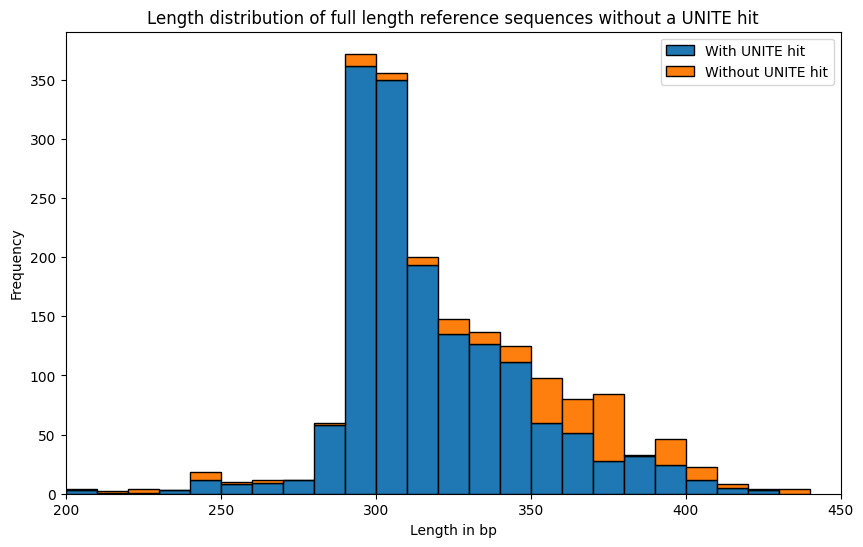

count
passed_contam_full tax_missing_full tax_missing_trunc refseq_trunc_exclusive_to_loc refseq_trunc_new_to_loc       
False              NaN              False             True                          False                      137
                                                                                    True                        23
                                                      False                         False                       14
                                                                                    True                         2
                                    True              True                          False                       48
                                                                                    True                         7
                                                      False                         False                        2
True               False            False             True                          False                     1466
                                                      False                         False                       51
                                    True              True                          False                        1
                   True             False             True                          False                       10
                                    True              True                          False                      206
                                                      False                         False                        3

- 217 are missing a UNITE hit (12.28%)
	- 7 of these are new reference sequences (23.33% of new reference sequences)
	- 3 of these are found in both locations (5.36% of reference sequences found in both locations)

In [114]:
#Missing taxonomy analysis

df_refseq_both_full_notax_count = pd.DataFrame.join(
    df_refseq_both_full.value_counts(
    subset=["passed_trunc", "tax_missing_full", "tax_missing_trunc", "refseq_full_exclusive_to_loc"], dropna=False),
    df_refseq_both_full[df_refseq_both_full["passed_trunc"] == True].drop_duplicates(subset=["tax_missing_full", "tax_missing_trunc", "refseq_full_exclusive_to_loc", "refsequence_pk_trunc"]).value_counts(
    subset=["passed_trunc", "tax_missing_full", "tax_missing_trunc", "refseq_full_exclusive_to_loc"], dropna=False),
    rsuffix=" trunc", lsuffix=" full"
).sort_index(level=["passed_trunc", "tax_missing_full", "tax_missing_trunc"], sort_remaining=False)
df_refseq_both_full_notax_count = df_refseq_both_full_notax_count.astype("Int64")

df_refseq_both_trunc_notax_count = pd.DataFrame(df_refseq_both_trunc.value_counts(
    subset=["passed_contam_full", "tax_missing_full", "tax_missing_trunc", "refseq_trunc_exclusive_to_loc", "refseq_trunc_new_to_loc"], dropna=False
)).sort_index(level=["passed_contam_full", "tax_missing_full", "tax_missing_trunc"], sort_remaining=False)


num_ref_full_notax = df_refseq_both_full_notax_count.loc[(slice(None), True, slice(None), slice(None))]["count full"].sum()
num_ref_full_notax_discard = df_refseq_both_full_notax_count.loc[(False, True, slice(None), slice(None))]["count full"].sum()
num_ref_full_notax_no_longer = df_refseq_both_full_notax_count.loc[(True, True, False, slice(None))]["count full"].sum()
num_ref_full_notax_not_exclusive = df_refseq_both_full_notax_count.loc[(True, True, slice(None), False)]["count full"].sum()
display(md("## Reference sequences missing a taxonomy hit"))

display(df_refseq_both_full_notax_count)

display(md(f"- {num_ref_full_notax} are missing a UNITE hit ({num_ref_full_notax / num_ref_full:.2%})\n"
           f"\t- {num_ref_full_notax_discard} of these are discarded reference sequences ({num_ref_full_notax_discard / num_ref_full_discarded:.2%} of total discarded)\n"
           f"\t- {num_ref_full_notax_no_longer} of these do have a UNITE hit after truncation ({num_ref_full_notax_no_longer / (num_ref_full_exclusive_both + num_ref_full_not_exclusive_both + num_ref_full_no_longer_exclusive):.2%} of reference sequences that pass truncation)\n"
           f"\t- {num_ref_full_notax_not_exclusive} of these are are found in both locations ({num_ref_full_notax_not_exclusive / num_ref_full_not_exclusive_both:.2%} of reference sequences found in both locations)"))

df_refseq_both_full_notax_count.to_latex(os.path.join(latex_tables, "refseq_notax_full.tex"), escape=True)

ax = df_refseq_both_full.pivot(columns="tax_missing_full")["refseq_length_full"]\
    .rename(columns={True: "Without UNITE hit", False: "With UNITE hit"}).plot.hist(bins=bins, stacked=True, xlim=(200, 450), edgecolor = "black", figsize=(10,6))
ax.set_title("Length distribution of full length reference sequences without a UNITE hit")
ax.set_xlabel("Length in bp")
plt.legend() 
plt.show()


num_ref_trunc_notax_new = df_refseq_both_trunc_notax_count.loc[(False, slice(None), True, slice(None), True)]["count"].sum()
num_ref_trunc_notax_overlap = df_refseq_both_trunc_notax_count.loc[(True, slice(None), True, slice(None), False)]["count"].sum()
num_ref_trunc_notax = num_ref_trunc_notax_new + num_ref_trunc_notax_overlap
num_ref_trunc_notax_not_exclusive = df_refseq_both_trunc_notax_count.loc[(True, slice(None), True, False, False)]["count"].sum()

display(df_refseq_both_trunc_notax_count)

display(md(f"- {num_ref_trunc_notax} are missing a UNITE hit ({num_ref_trunc_notax / num_ref_trunc:.2%})\n"
           f"\t- {num_ref_trunc_notax_new} of these are new reference sequences ({num_ref_trunc_notax_new / num_ref_trunc_exclusive_new:.2%} of new reference sequences)\n"
           f"\t- {num_ref_trunc_notax_not_exclusive} of these are found in both locations ({num_ref_trunc_notax_not_exclusive / (num_ref_trunc_not_exclusive_both + num_ref_trunc_not_exclusive_new + num_ref_trunc_no_longer_exclusive):.2%} of reference sequences found in both locations)"))

df_refseq_both_trunc_notax_count.to_latex(os.path.join(latex_tables, "refseq_notax_trunc.tex"), escape=True)


# Taxonomy of discarded refseqs present in remaining full length and truncated refseqs

count refseq  \
UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest                 
False                   False                    species                   species                               15   
                                                 order                     order                                  4   
                                                 class                     species                                1   

                                                                                                       count UNITE_id  
UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest                  
False                   False                    species                   species                                 10  
                                                 order                     order                                    3  
                                                 class                     species                                  1

# Taxonomy of new refseqs present in remaining truncated and full length refseqs

count refseq  \
UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest                 
True                    True                     species                   species                               13   
False                   False                    species                   species                                5   
                                                 order                     order                                  3   
                                                 family                    family                                 2   
                                                 class                     class                                  1   
                                                 species                   class                                  1   

                                                                                                       count UNITE_id  
UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest                  
True                    True                     species                   species                                 12  
False                   False                    species                   species                                  5  
                                                 order                     order                                    3  
                                                 family                    family                                   2  
                                                 class                     class                                    1  
                                                 species                   class                                    1

# Taxonomy of remaining full length refseqs present in truncated refseqs

count refseq  \
UNITE_id_in_refseq_trunc tax_in_refseq_trunc_lowest                 
True                     species                             1383   
False                    genus                                138   
                         species                               63   
                         family                                31   
                         order                                 13   
                         class                                  2   

                                                     count UNITE_id  
UNITE_id_in_refseq_trunc tax_in_refseq_trunc_lowest                  
True                     species                                825  
False                    genus                                   86  
                         species                                 50  
                         family                                  21  
                         order                                    9  
                         class                                    2

# Taxonomy difference after trunction and effect on taxa found in location

refsequence_pk_full  \
UNITE_id_equal tax_equal_lowest tax_change_below_equal                        
True           species          none                                   1285   
False          species          none                                     36   
               genus            uniden->uniden                            6   
                                species->species                        132   
               family           uniden->genus                             3   
                                genus->uniden                            10   
                                genus->genus                             36   
               order            uniden->family                           12   
                                family->uniden                           16   
                                family->family                           10   
               class            uniden->order                             4   
                                order->uniden                             1   
                                order->order                              3   
               phylum           uniden->uniden                            1   
                                uniden->class                            10   
                                class->uniden                             5   
               none             uniden->phylum                            5   
                                phylum->uniden                            6   

                                                        UNITE_id_full  
UNITE_id_equal tax_equal_lowest tax_change_below_equal                 
True           species          none                              781  
False          species          none                               33  
               genus            uniden->uniden                      5  
                                species->species                   95  
               family           uniden->genus                       2  
                                genus->uniden                      10  
                                genus->genus                       26  
               order            uniden->family                      5  
                                family->uniden                     13  
                                family->family                      7  
               class            uniden->order                       3  
                                order->uniden                       1  
                                order->order                        3  
               phylum           uniden->uniden                      1  
                                uniden->class                       2  
                                class->uniden                       4  
               none             uniden->phylum                      3  
                                phylum->uniden                      4

# Taxonomy difference after trunction plotted against refseq length

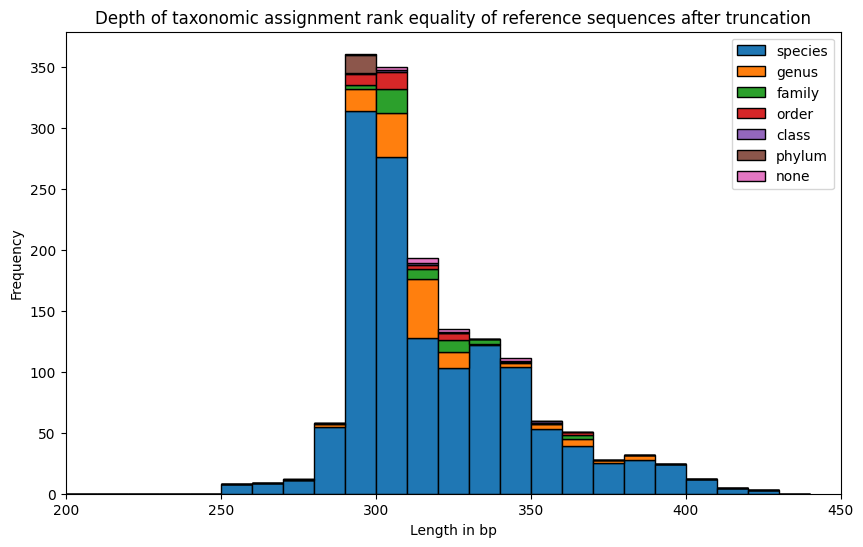

In [115]:
#Create UNITE id dataframes
df_unite_full = df[df["tax_missing_full"] == False].drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_not_discard = df[(df["passed_trunc"] == True) & (df["tax_missing_full"] == False)].drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_trunc = df[df["tax_missing_trunc"] == False].drop_duplicates(subset=["location", "UNITE_id_trunc"])
df_unite_not_new = df_refseq_both[
    (df_refseq_both["passed_contam_trunc"] == True) &
    (df_refseq_both["refseq_trunc_new_to_loc"] == False) &
    (df_refseq_both["tax_missing_trunc"] == False)].drop_duplicates(subset=["location", "UNITE_id_trunc"])

df_refseq_unite_discard = df_refseq_both[(df_refseq_both["passed_trunc"] == False) & (df_refseq_both["tax_missing_full"] == False)].copy()
df_refseq_unite_new = df_refseq_both[(df_refseq_both["passed_contam_trunc"] == True) & (df_refseq_both["refseq_trunc_new_to_loc"] == True) &
    (df_refseq_both["tax_missing_trunc"] == False)].copy()
df_refseq_unite_both = df_refseq_both[(df_refseq_both["tax_missing_full"] == False) & (df_refseq_both["tax_missing_trunc"] == False)].copy()

#---------------------------------------------------
# Analyse discarded

for suffix, merge_df in [("full", df_unite_not_discard), ("trunc", df_unite_trunc)]:

    df_refseq_unite_discard = df_refseq_unite_discard.merge(
        merge_df[["location", f"UNITE_id_{suffix}"]].rename(columns={f"UNITE_id_{suffix}": "UNITE_id_full"}),
        on=["location","UNITE_id_full"], how="left", indicator=True).set_index(df_refseq_unite_discard.index)
    df_refseq_unite_discard[f"UNITE_id_in_refseq_{suffix}"] = df_refseq_unite_discard["_merge"] == "both"
    df_refseq_unite_discard = df_refseq_unite_discard.drop(columns=["_merge"])

    for rank_depth in range(len(ranks)):
        df_tax_until_rank = merge_df[["location"]+[f"{rank}_{suffix}" for rank in ranks[:rank_depth+1]]].drop_duplicates()
        df_refseq_unite_discard = df_refseq_unite_discard.merge(
            df_tax_until_rank.rename(columns={f"{rank}_{suffix}": f"{rank}_full" for rank in ranks[:rank_depth+1]}),
            how="left", indicator=True).set_index(df_refseq_unite_discard.index)
        df_refseq_unite_discard[f"tax_in_refseq_{suffix}_until_{ranks[rank_depth]}"] = df_refseq_unite_discard["_merge"] == "both"
        df_refseq_unite_discard = df_refseq_unite_discard.drop(columns=["_merge"])

    df_refseq_unite_discard[f"tax_in_refseq_{suffix}_lowest"] = (
        df_refseq_unite_discard[[f"tax_in_refseq_{suffix}_until_{rank}" for rank in ranks]].apply(
            lambda row: next((rank for rank in ranks[::-1] if row[f"tax_in_refseq_{suffix}_until_{rank}"]), None), axis=1
        )
    )

df_unite_discard = df_refseq_unite_discard.drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_discard_counts = pd.DataFrame.join(
    df_refseq_unite_discard.value_counts(subset=["UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"]),
    df_unite_discard.value_counts(subset=["UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"]),
    lsuffix=" refseq", rsuffix=" UNITE_id"
)

display(md("# Taxonomy of discarded refseqs present in remaining full length and truncated refseqs"))
display(df_unite_discard_counts)

df_unite_discard_counts.to_latex(os.path.join(latex_tables, "unite_discard.tex"), escape=True)


#---------------------------------------------------
# Analyze new refseqs

for suffix, merge_df in [("full", df_unite_full), ("trunc", df_unite_not_new)]:

    df_refseq_unite_new = df_refseq_unite_new.merge(
        merge_df[["location", f"UNITE_id_{suffix}"]].rename(columns={f"UNITE_id_{suffix}": "UNITE_id_trunc"}),
        on=["location","UNITE_id_trunc"], how="left", indicator=True).set_index(df_refseq_unite_new.index)
    df_refseq_unite_new[f"UNITE_id_in_refseq_{suffix}"] = df_refseq_unite_new["_merge"] == "both"
    df_refseq_unite_new = df_refseq_unite_new.drop(columns=["_merge"])

    for rank_depth in range(len(ranks)):
        df_tax_until_rank = merge_df[["location"]+[f"{rank}_{suffix}" for rank in ranks[:rank_depth+1]]].drop_duplicates()
        df_refseq_unite_new = df_refseq_unite_new.merge(
            df_tax_until_rank.rename(columns={f"{rank}_{suffix}": f"{rank}_trunc" for rank in ranks[:rank_depth+1]}),
            how="left", indicator=True).set_index(df_refseq_unite_new.index)
        df_refseq_unite_new[f"tax_in_refseq_{suffix}_until_{ranks[rank_depth]}"] = df_refseq_unite_new["_merge"] == "both"
        df_refseq_unite_new = df_refseq_unite_new.drop(columns=["_merge"])

    df_refseq_unite_new[f"tax_in_refseq_{suffix}_lowest"] = (
        df_refseq_unite_new[[f"tax_in_refseq_{suffix}_until_{rank}" for rank in ranks]].apply(
            lambda row: next((rank for rank in ranks[::-1] if row[f"tax_in_refseq_{suffix}_until_{rank}"]), "none"), axis=1
        )
    )

df_unite_new = df_refseq_unite_new.drop_duplicates(subset=["location", "UNITE_id_trunc"])
df_unite_new_counts = pd.DataFrame.join(
    df_refseq_unite_new.value_counts(subset=["UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"]),
    df_unite_new.value_counts(subset=["UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"]),
    lsuffix=" refseq", rsuffix=" UNITE_id"
)

display(md("# Taxonomy of new refseqs present in remaining truncated and full length refseqs"))
display(df_unite_new_counts)

df_unite_new_counts.to_latex(os.path.join(latex_tables, "unite_new.tex"), escape=True)

#---------------------------------------------------
# Analyze refseqs that have a UNITE hit before and after truncation
df_refseq_unite_both["UNITE_id_equal"] = df_refseq_unite_both["UNITE_id_full"] == df_refseq_unite_both["UNITE_id_trunc"]

def deepest_rank_equal(row):
    last_rank_equal = "none"
    for rank in ranks:
        if row[f"{rank}_full"] == row[f"{rank}_trunc"]:
            last_rank_equal = rank
        else:
            break
    return last_rank_equal

def rank_unequal_change(row):
    tax_equal_lowest = row["tax_equal_lowest"]
    if tax_equal_lowest == "none":
        tax_equal_lowest_index = -1
    elif tax_equal_lowest == "species":
        return "none"
    else:
        tax_equal_lowest_index = ranks.index(tax_equal_lowest)
    first_unequal_rank = ranks[tax_equal_lowest_index + 1]
    uniden_full = "Incertae_sedis" in row[f"{first_unequal_rank}_full"] or "_sp" in row[f"{first_unequal_rank}_full"]
    uniden_trunc = "Incertae_sedis" in row[f"{first_unequal_rank}_trunc"] or "_sp" in row[f"{first_unequal_rank}_full"]
    if uniden_full:
        if uniden_trunc:
            return "uniden->uniden"
        else:
            return f"uniden->{first_unequal_rank}"
    elif uniden_trunc:
        return f"{first_unequal_rank}->uniden"
    else:
        return f"{first_unequal_rank}->{first_unequal_rank}"
    

df_refseq_unite_both["tax_equal_lowest"] = df_refseq_unite_both.apply(deepest_rank_equal, axis=1)
df_refseq_unite_both["tax_change_below_equal"] = df_refseq_unite_both.apply(rank_unequal_change, axis=1)

df_refseq_unite_both = df_refseq_unite_both.merge(
    df_unite_trunc[["location", f"UNITE_id_trunc"]].rename(columns={f"UNITE_id_trunc": "UNITE_id_full"}),
    on=["location","UNITE_id_full"], how="left", indicator=True).set_index(df_refseq_unite_both.index)
df_refseq_unite_both[f"UNITE_id_in_refseq_trunc"] = df_refseq_unite_both["_merge"] == "both"
df_refseq_unite_both = df_refseq_unite_both.drop(columns=["_merge"])

# Up to every taxonomic rank in the full length refseqs check if it is also present in the truncated refseqs
for rank_depth in range(len(ranks)):
    df_tax_until_rank = df_unite_trunc[["location"]+[f"{rank}_trunc" for rank in ranks[:rank_depth+1]]].drop_duplicates()
    df_refseq_unite_both = df_refseq_unite_both.merge(
        df_tax_until_rank.rename(columns={f"{rank}_trunc": f"{rank}_full" for rank in ranks[:rank_depth+1]}),
        how="left", indicator=True).set_index(df_refseq_unite_both.index)
    df_refseq_unite_both[f"tax_in_refseq_trunc_until_{ranks[rank_depth]}"] = df_refseq_unite_both["_merge"] == "both"
    df_refseq_unite_both = df_refseq_unite_both.drop(columns=["_merge"])

df_refseq_unite_both[f"tax_in_refseq_trunc_lowest"] = (
    df_refseq_unite_both[[f"tax_in_refseq_trunc_until_{rank}" for rank in ranks]].apply(
        lambda row: next((rank for rank in ranks[::-1] if row[f"tax_in_refseq_trunc_until_{rank}"]), "none"), axis=1
    )
)

# Up to every taxonomic rank in the truncated length refseqs check if it is also present in the full length refseqs
for rank_depth in range(len(ranks)):
    df_tax_until_rank = df_unite_full[["location"]+[f"{rank}_full" for rank in ranks[:rank_depth+1]]].drop_duplicates()
    df_refseq_unite_both = df_refseq_unite_both.merge(
        df_tax_until_rank.rename(columns={f"{rank}_full": f"{rank}_trunc" for rank in ranks[:rank_depth+1]}),
        how="left", indicator=True).set_index(df_refseq_unite_both.index)
    df_refseq_unite_both[f"tax_in_refseq_full_until_{ranks[rank_depth]}"] = df_refseq_unite_both["_merge"] == "both"
    df_refseq_unite_both = df_refseq_unite_both.drop(columns=["_merge"])

df_refseq_unite_both[f"tax_in_refseq_full_lowest"] = (
    df_refseq_unite_both[[f"tax_in_refseq_full_until_{rank}" for rank in ranks]].apply(
        lambda row: next((rank for rank in ranks[::-1] if row[f"tax_in_refseq_full_until_{rank}"]), "none"), axis=1
    )
)

df_unite_both_full = df_refseq_unite_both.drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_both_count_overlap = pd.DataFrame.join(
    df_refseq_unite_both.value_counts(subset=["UNITE_id_in_refseq_trunc", "tax_in_refseq_trunc_lowest"]),
    df_unite_both_full.value_counts(subset=["UNITE_id_in_refseq_trunc", "tax_in_refseq_trunc_lowest"]),
    lsuffix=" refseq", rsuffix=" UNITE_id"
)

display(md("# Taxonomy of remaining full length refseqs present in truncated refseqs"))
display(df_unite_both_count_overlap)

df_unite_both_count_overlap.to_latex(os.path.join(latex_tables, "unite_both_overlap.tex"), escape=True)

#---------------------------------------------------
# Difference in taxonomic assignment after truncation

def highlight_negative(val):
    if val < 0:
        return 'background-color: darkred'
    return ''

def highlight_positive(val):
    if val > 0:
        return 'background-color: darkgreen'
    return ''

df_unite_both = df_refseq_unite_both.drop_duplicates(subset=["UNITE_id_full", "UNITE_id_trunc"])
df_unite_both_count_equal = df_refseq_unite_both.drop_duplicates(subset="refsequence_pk_full").groupby(by=["UNITE_id_equal", "tax_equal_lowest", "tax_change_below_equal"]).agg({"refsequence_pk_full": "count"})
df_unite_both_count_equal = df_unite_both_count_equal.join(df_unite_both.groupby(by=["UNITE_id_equal", "tax_equal_lowest", "tax_change_below_equal"]).agg({"UNITE_id_full": "count"}))
#for rank in ranks:
#    df_unite_both_count_equal = df_unite_both_count_equal.join(
#        df_refseq_unite_both[~df_refseq_unite_both[f"tax_in_refseq_trunc_until_{rank}"]]\
#            .groupby(by=["UNITE_id_equal", "tax_equal_lowest", "tax_change_below_equal"])[f"{rank}_full"].nunique()*-1
#    )
#    df_unite_both_count_equal = df_unite_both_count_equal.join(
#        df_refseq_unite_both[~df_refseq_unite_both[f"tax_in_refseq_full_until_{rank}"]]\
#            .groupby(by=["UNITE_id_equal", "tax_equal_lowest", "tax_change_below_equal"])[f"{rank}_trunc"].nunique()
#    )

df_unite_both_count_equal = df_unite_both_count_equal.sort_index(level=0, ascending=False).reindex(level=1, index=ranks[::-1]+['none'])
#df_unite_both_count_equal = df_unite_both_count_equal.fillna(0).astype(int)
#df_unite_both_count_equal.columns = pd.MultiIndex.from_tuples([('refseq', ''),('UNITE_id mapping', '')]+[(rank, suffix) for rank in ranks for suffix in ("full", "trunc")])

#df_unite_both_count_equal_styled = df_unite_both_count_equal.style.map(highlight_negative, subset=[(rank, "full") for rank in ranks])
#df_unite_both_count_equal_styled = df_unite_both_count_equal_styled.map(highlight_positive, subset=[(rank, "trunc") for rank in ranks])

display(md("# Taxonomy difference after trunction and effect on taxa found in location"))
#display(df_unite_both_count_equal_styled)
display(df_unite_both_count_equal)

df_unite_both_count_equal.to_latex(os.path.join(latex_tables, "unite_both_equal.tex"), escape=True)


#---------------------------------------------------
# Plot difference in taxonomic assignment against refseq length

df_refseq_unite_both_global = df_refseq_unite_both.drop_duplicates(subset=["refsequence_pk_full"])
ax = df_refseq_unite_both_global.pivot(columns="tax_equal_lowest")["refseq_length_full"].reindex(ranks[::-1]+["none"], axis=1).plot.hist(bins=bins, stacked=True, xlim=(200, 450), edgecolor = "black", figsize=(10,6))
ax.set_title("Depth of taxonomic assignment rank equality of reference sequences after truncation")
ax.set_xlabel("Length in bp")

display(md("# Taxonomy difference after trunction plotted against refseq length"))

plt.legend()
plt.show()




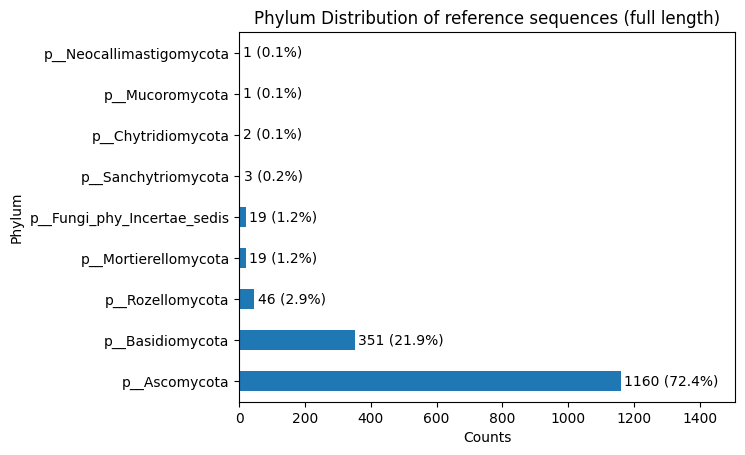

In [116]:
value_counts = df_refseq_tax_full["phylum"].value_counts()
proportions = value_counts / value_counts.sum()
ax = value_counts.plot.barh(xlim=(0, value_counts.max() * 1.3))

for index, (count, proportion) in enumerate(zip(value_counts, proportions)):
    ax.text(count + 10, index, f"{count} ({proportion:.1%})", va='center')

ax.set_xlabel("Counts")
ax.set_ylabel("Phylum")
ax.set_title("Phylum Distribution of reference sequences (full length)")

plt.show()

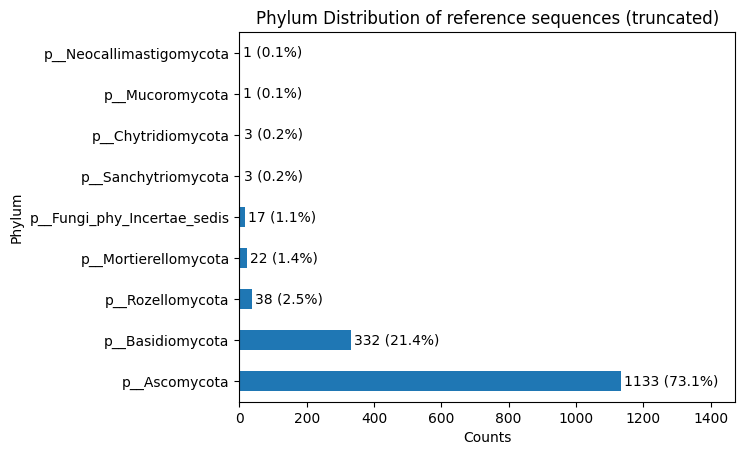

In [117]:
value_counts = df_refseq_tax["phylum"].value_counts()
proportions = value_counts / value_counts.sum()
ax = value_counts.plot.barh(xlim=(0, value_counts.max() * 1.3))

for index, (count, proportion) in enumerate(zip(value_counts, proportions)):
    ax.text(count + 10, index, f"{count} ({proportion:.1%})", va='center')

ax.set_xlabel("Counts")
ax.set_ylabel("Phylum")
ax.set_title("Phylum Distribution of reference sequences (truncated)")

plt.show()

# Subtree determination results

In [118]:
# Group together BLAST results

df_phylo_blast_full["maj_split_tax"] = df_phylo_blast_full["maj_chunk"].str.extract(r"^.+_(\w__.+)$")
df_phylo_blast_full["maj_split_rank"] = df_phylo_blast_full["maj_split_tax"].str[:1].map({r[0]: r for r in ranks})

df_phylo_compare_full = df_refseq_tax_merged_full.merge(df_phylo_blast_full, how="left", indicator=True)
df_phylo_compare_full["chunk_missing"] = df_phylo_compare_full["_merge"] == "left_only"
df_phylo_compare_full = df_phylo_compare_full.drop(columns=["_merge"])

def compare_tax(row):
    split_rank = row['maj_split_rank']
    if split_rank is np.nan:
        return np.nan
    return row[split_rank] == row['maj_split_tax']

def split_rank_unidentified(row):
    split_rank = row['maj_split_rank']
    if split_rank is np.nan:
        return np.nan
    if row[split_rank] is np.nan:
        return np.nan
    return 'Incertae_sedis' in row[split_rank]

df_phylo_compare_full["maj_split_rank_equal"] = df_phylo_compare_full.apply(compare_tax, axis=1)
df_phylo_compare_full["maj_split_rank_uniden"] = df_phylo_compare_full.apply(split_rank_unidentified, axis=1)
df_phylo_compare_full["length <250bp"] = df_phylo_compare_full["refseq_length"] < 250

display(md("# Result of subtree determinaton on full length reference sequences"))

display(pd.DataFrame(df_phylo_compare_full.groupby(by=["tax_missing", "chunk_missing", "maj_split_rank_equal"], dropna=False).agg({'refsequence_pk': ['count'], 'num_chunks': ['median'], 'maj_chunk_count': ['median']})))

# Inocybaceae is one of the largest families. Probably the result of new information in the more recent unite db
display(pd.DataFrame(df_phylo_compare_full[
    (df_phylo_compare_full["tax_missing"] == False) &
    (df_phylo_compare_full["chunk_missing"] == True)
].value_counts(subset=["order", "family", "length <250bp"])))


# Result of subtree determinaton on full length reference sequences

refsequence_pk num_chunks  \
                                                        count     median   
tax_missing chunk_missing maj_split_rank_equal                             
False       False         False                           386        3.0   
                          True                           1073        1.0   
            True          NaN                             143        NaN   
True        False         False                           164        3.0   
            True          NaN                              90        NaN   

                                               maj_chunk_count  
                                                        median  
tax_missing chunk_missing maj_split_rank_equal                  
False       False         False                            7.0  
                          True                            10.0  
            True          NaN                              NaN  
True        False         False                            6.0  
            True          NaN                              NaN

count
order                               family                              length <250bp       
o__Agaricales                       f__Inocybaceae                      False            123
o__Rozellomycota_ord_Incertae_sedis f__Rozellomycota_fam_Incertae_sedis True               7
                                                                        False              5
o__Saccharomycetales                f__Dipodascaceae                    True               3
o__Fungi_ord_Incertae_sedis         f__Fungi_fam_Incertae_sedis         False              2
                                                                        True               2
o__Sporidesmiales                   f__Sporidesmiaceae                  False              1

In [119]:
# Group together BLAST results

df_phylo_blast["maj_split_tax"] = df_phylo_blast["maj_chunk"].str.extract(r"^.+_(\w__.+)$")
df_phylo_blast["maj_split_rank"] = df_phylo_blast["maj_split_tax"].str[:1].map({r[0]: r for r in ranks})

df_phylo_compare_trunc = df_refseq_tax_merged.merge(df_phylo_blast, how="outer", indicator=True)
df_phylo_compare_trunc["chunk_missing"] = df_phylo_compare_trunc["_merge"] == "left_only"
df_phylo_compare_trunc = df_phylo_compare_trunc.drop(columns=["_merge"])

df_phylo_compare_trunc["maj_split_rank_equal"] = df_phylo_compare_trunc.apply(compare_tax, axis=1)
df_phylo_compare_trunc["maj_split_rank_uniden"] = df_phylo_compare_trunc.apply(split_rank_unidentified, axis=1)

display(md("# Result of subtree determinaton on truncated reference sequences"))

display(pd.DataFrame(df_phylo_compare_trunc.groupby(by=["tax_missing", "chunk_missing", "maj_split_rank_equal"], dropna=False).agg({'refsequence_pk': ['count'], 'num_chunks': ['median'], 'maj_chunk_count': ['median']})))

# Inocybaceae is one of the largest families. Probably the result of new information in the more recent unite db
display(pd.DataFrame(df_phylo_compare_trunc[
    (df_phylo_compare_trunc["tax_missing"] == False) &
    (df_phylo_compare_trunc["chunk_missing"] == True)
].value_counts(subset=["order", "family"])))


# Result of subtree determinaton on truncated reference sequences

refsequence_pk num_chunks  \
                                                        count     median   
tax_missing chunk_missing maj_split_rank_equal                             
False       False         False                           382        3.0   
                          True                           1043        1.0   
            True          NaN                             125        NaN   
True        False         False                           143        4.0   
            True          NaN                              74        NaN   

                                               maj_chunk_count  
                                                        median  
tax_missing chunk_missing maj_split_rank_equal                  
False       False         False                            7.0  
                          True                            10.0  
            True          NaN                              NaN  
True        False         False                            6.0  
            True          NaN                              NaN

,,count
order,family,
o__Agaricales,f__Inocybaceae,119
o__Rozellomycota_ord_Incertae_sedis,f__Rozellomycota_fam_Incertae_sedis,5
o__Sporidesmiales,f__Sporidesmiaceae,1


In [120]:
df_phylo_compare_both = df_refseq_unite_both_global.merge(df_phylo_compare_full.add_suffix("_full"), how="left").set_index(df_refseq_unite_both_global.index)
df_phylo_compare_both = df_phylo_compare_both.merge(df_phylo_compare_trunc.add_suffix("_trunc"), how="left").set_index(df_phylo_compare_both.index)

df_phylo_compare_both["maj_chunk_equal"] = df_phylo_compare_both["maj_chunk_full"] == df_phylo_compare_both["maj_chunk_trunc"]
df_phylo_compare_both["maj_split_rank_equal_either"] = df_phylo_compare_both["maj_split_rank_equal_full"] | df_phylo_compare_both["maj_split_rank_equal_trunc"]
df_phylo_compare_both["maj_split_rank_uniden_either"] = df_phylo_compare_both["maj_split_rank_uniden_full"] | df_phylo_compare_both["maj_split_rank_uniden_trunc"]

display(md("# Difference in subtree determination before and after truncation"))

df_phylo_compare_both_count = pd.DataFrame(df_phylo_compare_both.groupby(
    by=["tax_equal_lowest", "chunk_missing_full", "chunk_missing_trunc", "maj_chunk_equal", "maj_split_rank_equal_either"]).agg({'refsequence_pk_full': ['count'], 'num_chunks_full': ['median'], 'num_chunks_trunc': ['median'], 'maj_chunk_count_full': ['median'], 'maj_chunk_count_trunc': ['median']}).reindex(level=0, index=ranks[::-1]+['none']))
display(df_phylo_compare_both_count)

display(pd.DataFrame(df_phylo_compare_both[
    (df_phylo_compare_both["tax_equal_lowest"] == "species") &
    (df_phylo_compare_both["chunk_missing_full"])].value_counts(subset=["order_full", "family_full"]))
)

#Example showing that majority chunks mostly stay the same even if there is a difference in rank taxonomy below splitting level
display(df_phylo_compare_both[
    (df_phylo_compare_both["tax_equal_lowest"] == "class")
][["order_full", "order_trunc", "maj_split_tax_full", "maj_split_tax_trunc"]])

# Difference in subtree determination before and after truncation

refsequence_pk_full  \
                                                                                                                  count   
tax_equal_lowest chunk_missing_full chunk_missing_trunc maj_chunk_equal maj_split_rank_equal_either                       
species          False              False               False           False                                         3   
                                                                        True                                          1   
                                                        True            False                                       338   
                                                                        True                                        850   
                 True               True                False           False                                       129   
genus            False              False               True            False                                         8   
                                                                        True                                        130   
family           False              False               True            True                                         49   
order            False              False               True            False                                         2   
                                                                        True                                         36   
class            False              False               True            False                                         1   
                                                                        True                                          7   
phylum           False              False               True            False                                        15   
                                                                        True                                          1   
none             False              False               True            False                                         2   
                                                                        True                                          7   
                 True               True                False           False                                         2   

                                                                                                    num_chunks_full  \
                                                                                                             median   
tax_equal_lowest chunk_missing_full chunk_missing_trunc maj_chunk_equal maj_split_rank_equal_either                   
species          False              False               False           False                                   5.0   
                                                                        True                                    3.0   
                                                        True            False                                   3.0   
                                                                        True                                    1.0   
                 True               True                False           False                                   NaN   
genus            False              False               True            False                                   3.0   
                                                                        True                                    1.0   
family           False              False               True            True                                    1.0   
order            False              False               True            False                                   1.5   
                                                                        True                                    1.0   
class            False              False               True            False               

,,count
order_full,family_full,
o__Agaricales,f__Inocybaceae,123
o__Rozellomycota_ord_Incertae_sedis,f__Rozellomycota_fam_Incertae_sedis,5
o__Sporidesmiales,f__Sporidesmiaceae,1


,order_full,order_trunc,maj_split_tax_full,maj_split_tax_trunc
1953,o__Agaricomycetes_ord_Incertae_sedis,o__Trechisporales,o__Trechisporales,o__Trechisporales
3075,o__Agaricomycetes_ord_Incertae_sedis,o__Trechisporales,o__Trechisporales,o__Trechisporales
8640,o__Sordariales,o__Sordariomycetes_ord_Incertae_sedis,o__Sordariales,o__Sordariales
15859,o__Sordariomycetes_ord_Incertae_sedis,o__Hypocreales,o__Hypocreales,o__Hypocreales
51146,o__Sordariomycetes_ord_Incertae_sedis,o__Microascales,o__Microascales,o__Microascales
55322,o__Leotiales,o__Thelebolales,o__Thelebolales,o__Thelebolales
57033,o__Leotiales,o__Helotiales,o__Onygenales,o__Onygenales
59552,o__Hypocreales,o__Diaporthales,o__Diaporthales,o__Diaporthales


# Phylogenetic placement results

In [4]:
import json
from ete3 import Tree
import os
import re

def process_tree(tree_str):
    pattern = re.compile(r"([\w.]*)(:?[\d.e-]*){(\d+)}")
    matches = pattern.findall(tree_str)

    leaf_to_node = {leaf: node_num for leaf, dist, node_num in matches if leaf}

    result = pattern.sub(r"\3\2", tree_str)
    tree = Tree(result, format=1)
    
    return leaf_to_node, tree

def load_jplace(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    tree_str = data['tree']
    placements = data['placements']

    leaf_to_node, tree = process_tree(tree_str)

    return leaf_to_node, tree, placements

def get_placement_info(placements):
    placement_info_full, placement_info_trunc = {}, {}
    for placement in placements:
        refseqs = [x[0] for x in placement['nm']]
        placement_info = [(p[1], p[2], p[4]) for p in placement['p']]
        for refseq in refseqs:
            if "_full" in refseq:
                placement_info_full[refseq] = placement_info
            else:
                placement_info_trunc[refseq] = placement_info

    return placement_info_full, placement_info_trunc

def get_longest_branch(tree):
    return max(node.dist for node in tree.traverse() if node.dist is not None)

def get_max_tree_depth(tree):
    return max(leaf.get_distance(tree.get_tree_root()) for leaf in tree)

def calculate_node_distance(tree, longest_branch, node1_num, node2_num):
    node1 = tree&node1_num
    node2 = tree&node2_num

    node_difference = tree.get_distance(node1, node2, topology_only=True)
    node_distance = tree.get_distance(node1, node2) / longest_branch

    return node_difference, node_distance

def calc_kl_divergence(refseq_full_placements, refseq_trunc_placements, epsilon=1e-10):
    prob_full = {node: prob for node, prob, _ in refseq_full_placements}
    prob_trunc = {node: prob for node, prob, _ in refseq_trunc_placements}

    all_nodes = set(prob_full.keys()).union(set(prob_trunc.keys()))

    p = np.array([prob_full.get(node, epsilon) for node in all_nodes])
    q = np.array([prob_trunc.get(node, epsilon) for node in all_nodes])

    kl_div = np.sum(p * np.log(p / q))

    return round(kl_div, 4)

def calc_own_divergence(refseq_full_placements, refseq_trunc_placements, longest_branch):
    prob_full = {node: prob for node, prob, _ in refseq_full_placements}
    prob_trunc = {node: prob for node, prob, _ in refseq_trunc_placements}

    all_nodes = set(prob_full.keys()).union(set(prob_trunc.keys()))

    prob_full = {node: prob_full.get(node, 0) for node in all_nodes}
    prob_trunc = {node: prob_trunc.get(node, 0) for node in all_nodes}

    total_divergence = 0.0
    for node in all_nodes:
        node_prob_divergence = abs(prob_full[node] - prob_trunc[node])

        node_weighted_distance = 0.0
        for node2 in all_nodes:
            weight = prob_full[node] * prob_trunc[node2]
            dist = tree.get_distance(tree&node, tree&node2) / longest_branch
            node_weighted_distance += weight * dist
        
        total_divergence += node_prob_divergence * node_weighted_distance

    return round(total_divergence, 4)

def weighted_distance_divergence(tree, longest_branch, placements_full, placements_trunc):
    # Step 1: Create node-probability mappings
    prob_full = {node: prob for node, prob, _ in placements_full}
    prob_trunc = {node: prob for node, prob, _ in placements_trunc}
    
    # Step 2: Ensure all nodes are represented with epsilon probability if missing
    all_nodes = set(prob_full.keys()).union(set(prob_trunc.keys()))
    prob_full = {node: prob_full.get(node, 0) for node in all_nodes}
    prob_trunc = {node: prob_trunc.get(node, 0) for node in all_nodes}
    
    # Step 3: Calculate weighted distance divergence
    total_divergence = 0.0
    for node1 in all_nodes:
        for node2 in all_nodes:
            p1 = prob_full[node1]
            p2 = prob_trunc[node2]
            
            # Joint probability weight
            weight = p1 * p2
            
            if weight > 0:
                # Phylogenetic distance between nodes
                dist = tree.get_distance(tree&node1, tree&node2) / longest_branch
                total_divergence += weight * dist
    
    return round(total_divergence, 4)

def get_placements_difference(tree, chunk_num, placements_full, placements_trunc):
    longest_branch = get_longest_branch(tree)

    num_refseqs = len(tree.get_leaf_names()) - 1

    placement_difference = {}
    for refseq_full, refseq_full_placements in placements_full.items():
        refseq_trunc = refseq_full.split("->")[1]
        refseq_trunc_placements = placements_trunc.get(refseq_trunc, None)
        if refseq_trunc_placements is None:
            continue

        top_placement_full = refseq_full_placements[0]
        top_placement_trunc = refseq_trunc_placements[0]

        node_difference, node_distance = calculate_node_distance(tree, longest_branch, top_placement_full[0], top_placement_trunc[0])

        top_likelyhood_full = top_placement_full[1]
        top_likelyhood_trunc = top_placement_trunc[1]
        top_likelyhood_full_on_trunc = np.nan
        top_likelyhood_full_on_trunc_dif = np.nan
        for p in (p for p in refseq_trunc_placements if p[0] == top_placement_full[0]):
            top_likelyhood_full_on_trunc = p[1]
            top_likelyhood_full_on_trunc_dif = top_likelyhood_full - p[1]

        #kl_divergence = calc_kl_divergence(refseq_full_placements, refseq_trunc_placements)
        #own_divergence = calc_own_divergence(refseq_full_placements, refseq_trunc_placements, longest_branch)
        dist_divergence = weighted_distance_divergence(tree, longest_branch, refseq_full_placements, refseq_trunc_placements)

        placement_difference[(chunk_num, refseq_full)] = {
            "num_of_refseqs": num_refseqs,
            "top_node_difference": node_difference,
            "top_node_distance": node_distance,
            "top_likelyhood_full": top_likelyhood_full,
            "top_likelyhood_trunc": top_likelyhood_trunc,
            "top_likelyhood_full_on_trunc": top_likelyhood_full_on_trunc,
            "top_likelyhood_full_on_trunc_dif": top_likelyhood_full_on_trunc_dif,
            #"kl_divergence": kl_divergence,
            "dist_divergence": dist_divergence,
            #"own_divergence": own_divergence
            }
        
    
    return placement_difference

pplacer_dir = os.path.join(run_dir, "pplacer")

placements_difference_full = {}
for filename in sorted(os.listdir(pplacer_dir)):
    if filename.endswith(".jplace"):
        display(filename)
        jplace_path = os.path.join(pplacer_dir, filename)

        leaf_to_node, tree, placement = load_jplace(jplace_path)
        placement_info_full, placement_info_trunc = get_placement_info(placement)
        chunk_num = filename[:3]
        placements_difference = get_placements_difference(tree, chunk_num, placement_info_full, placement_info_trunc)
        placements_difference_full = placements_difference_full | placements_difference

df_place_diff = pd.DataFrame.from_dict(placements_difference_full, orient='index')
df_place_diff = df_place_diff.rename_axis(["chunk_num", "refseq_mapping"])
df_place_diff.to_csv("place_dif.csv")



'007_913_p__Basidiomycota_c__Agaricomycetes_o__Thelephorales.jplace'

'009_219_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Hygrophoraceae.jplace'

'010_767_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Cortinariaceae.jplace'

'011_681_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Inocybaceae.jplace'

'012_300_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Amanitaceae.jplace'

'014_158_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Agaricaceae.jplace'

'016_180_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Clavariaceae.jplace'

'017_26_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Hydnangiaceae.jplace'

'018_322_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Tricholomataceae.jplace'

'021_136_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Psathyrellaceae.jplace'

'022_104_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Strophariaceae.jplace'

'028_72_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Pluteaceae.jplace'

'032_72_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Bolbitiaceae.jplace'

'036_32_p__Basidiomycota_c__Agaricomycetes_o__Agaricales_f__Hymenogastraceae.jplace'

'048_221_p__Basidiomycota_c__Agaricomycetes_o__Hymenochaetales.jplace'

'049_973_p__Basidiomycota_c__Agaricomycetes_o__Polyporales.jplace'

'050_258_p__Basidiomycota_c__Agaricomycetes_o__Boletales.jplace'

'051_856_p__Basidiomycota_c__Agaricomycetes_o__Russulales.jplace'

'054_127_p__Basidiomycota_c__Agaricomycetes_o__Auriculariales.jplace'

'056_128_p__Basidiomycota_c__Agaricomycetes_o__Trechisporales.jplace'

'059_421_p__Basidiomycota_c__Agaricomycetes_o__Sebacinales.jplace'

'064_14_p__Basidiomycota_c__Agaricomycetes_o__Tremellodendropsidales.jplace'

'070_248_p__Basidiomycota_c__Tremellomycetes_o__Tremellales.jplace'

'071_25_p__Basidiomycota_c__Tremellomycetes_o__Cystofilobasidiales.jplace'

'072_39_p__Basidiomycota_c__Tremellomycetes_o__Trichosporonales.jplace'

'074_37_p__Basidiomycota_c__Tremellomycetes_o__Filobasidiales.jplace'

'081_56_p__Basidiomycota_c__Microbotryomycetes_o__Microbotryomycetes_ord_Incertae_sedis.jplace'

'086_44_p__Basidiomycota_c__Agaricostilbomycetes_o__Agaricostilbales.jplace'

'105_6_p__Basidiomycota_c__Spiculogloeomycetes_o__Spiculogloeales.jplace'

'116_23_p__Ascomycota_c__Dothideomycetes_o__Dothideomycetes_ord_Incertae_sedis.jplace'

'117_466_p__Ascomycota_c__Dothideomycetes_o__Capnodiales.jplace'

'118_1044_p__Ascomycota_c__Dothideomycetes_o__Pleosporales.jplace'

'119_7_p__Ascomycota_c__Dothideomycetes_o__Acrospermales.jplace'

'120_84_p__Ascomycota_c__Dothideomycetes_o__Tubeufiales.jplace'

'121_129_p__Ascomycota_c__Dothideomycetes_o__Botryosphaeriales.jplace'

'123_79_p__Ascomycota_c__Dothideomycetes_o__Venturiales.jplace'

'124_36_p__Ascomycota_c__Dothideomycetes_o__Myriangiales.jplace'

'128_12_p__Ascomycota_c__Dothideomycetes_o__Mytilinidales.jplace'

'130_13_p__Ascomycota_c__Dothideomycetes_o__Mytilinidiales.jplace'

'140_1031_p__Ascomycota_c__Leotiomycetes_o__Helotiales.jplace'

'142_91_p__Ascomycota_c__Leotiomycetes_o__Rhytismatales.jplace'

'143_23_p__Ascomycota_c__Leotiomycetes_o__Thelebolales.jplace'

'149_2248_p__Ascomycota_c__Eurotiomycetes_o__Eurotiales_f__Aspergillaceae.jplace'

'150_119_p__Ascomycota_c__Eurotiomycetes_o__Eurotiales_f__Trichocomaceae.jplace'

'152_30_p__Ascomycota_c__Eurotiomycetes_o__Eurotiales_f__Elaphomycetaceae.jplace'

'153_226_p__Ascomycota_c__Eurotiomycetes_o__Onygenales.jplace'

'154_499_p__Ascomycota_c__Eurotiomycetes_o__Chaetothyriales.jplace'

'155_196_p__Ascomycota_c__Eurotiomycetes_o__Verrucariales.jplace'

'161_82_p__Ascomycota_c__Sordariomycetes_o__Glomerellales.jplace'

'163_124_p__Ascomycota_c__Sordariomycetes_o__Microascales.jplace'

'164_346_p__Ascomycota_c__Sordariomycetes_o__Diaporthales.jplace'

'165_47_p__Ascomycota_c__Sordariomycetes_o__Coniochaetales.jplace'

'166_310_p__Ascomycota_c__Sordariomycetes_o__Sordariales.jplace'

'167_1082_p__Ascomycota_c__Sordariomycetes_o__Hypocreales.jplace'

'168_814_p__Ascomycota_c__Sordariomycetes_o__Xylariales.jplace'

'169_73_p__Ascomycota_c__Sordariomycetes_o__Magnaporthales.jplace'

'170_72_p__Ascomycota_c__Sordariomycetes_o__Chaetosphaeriales.jplace'

'173_25_p__Ascomycota_c__Sordariomycetes_o__Pleurotheciales.jplace'

'174_23_p__Ascomycota_c__Sordariomycetes_o__Myrmecridiales.jplace'

'176_110_p__Ascomycota_c__Sordariomycetes_o__Ophiostomatales.jplace'

'178_4_p__Ascomycota_c__Sordariomycetes_o__Hypoceales.jplace'

'179_16_p__Ascomycota_c__Sordariomycetes_o__Boliniales.jplace'

'183_9_p__Ascomycota_c__Sordariomycetes_o__Togniniales.jplace'

'191_9_p__Ascomycota_c__Sordariomycetes_o__Savoryellales.jplace'

'197_1038_p__Ascomycota_c__Lecanoromycetes_o__Lecanorales.jplace'

'200_157_p__Ascomycota_c__Lecanoromycetes_o__Peltigerales.jplace'

'202_89_p__Ascomycota_c__Lecanoromycetes_o__Acarosporales.jplace'

'203_104_p__Ascomycota_c__Lecanoromycetes_o__Pertusariales.jplace'

'206_60_p__Ascomycota_c__Lecanoromycetes_o__Trapeliales.jplace'

'207_305_p__Ascomycota_c__Lecanoromycetes_o__Teloschistales.jplace'

'210_54_p__Ascomycota_c__Lecanoromycetes_o__Lecideales.jplace'

'211_16_p__Ascomycota_c__Lecanoromycetes_o__Baeomycetales.jplace'

'214_6_p__Ascomycota_c__Lecanoromycetes_o__GS36.jplace'

'218_205_p__Ascomycota_c__Orbiliomycetes_o__Orbiliales.jplace'

'222_241_p__Ascomycota_c__Saccharomycetes_o__Saccharomycetales.jplace'

'228_65_p__Ascomycota_c__Geoglossomycetes_o__Geoglossales.jplace'

'231_28_p__Ascomycota_c__Archaeorhizomycetes_o__Archaeorhizomycetales.jplace'

'241_47_p__Rozellomycota_c__Rozellomycotina_cls_Incertae_sedis_o__GS05.jplace'

'242_12_p__Rozellomycota_c__Rozellomycotina_cls_Incertae_sedis_o__GS08.jplace'

'245_24_p__Rozellomycota_c__Rozellomycotina_cls_Incertae_sedis_o__GS11.jplace'

'247_3_p__Rozellomycota_c__Rozellomycotina_cls_Incertae_sedis_o__GS06.jplace'

'249_10_p__Rozellomycota_c__Rozellomycotina_cls_Incertae_sedis_o__GS10.jplace'

'252_3_p__Rozellomycota_c__Rozellomycotina_cls_Incertae_sedis_o__Branch03.jplace'

'254_43_p__Chytridiomycota_c__Spizellomycetes_o__Spizellomycetales.jplace'

'259_10_p__Chytridiomycota_c__Rhizophlyctidomycetes_o__Rhizophlyctidales.jplace'

'260_6_p__Chytridiomycota_c__Synchytriomycetes_o__Synchytriales.jplace'

'267_47_p__Mucoromycota_c__Mucoromycetes_o__Mucorales.jplace'

'269_13_p__Mucoromycota_c__Umbelopsidomycetes_o__Umbelopsidales.jplace'

'272_142_p__Mortierellomycota_c__Mortierellomycetes_o__Mortierellales.jplace'

'280_8_p__Monoblepharomycota_c__Sanchytriomycetes_o__Sanchytriales.jplace'

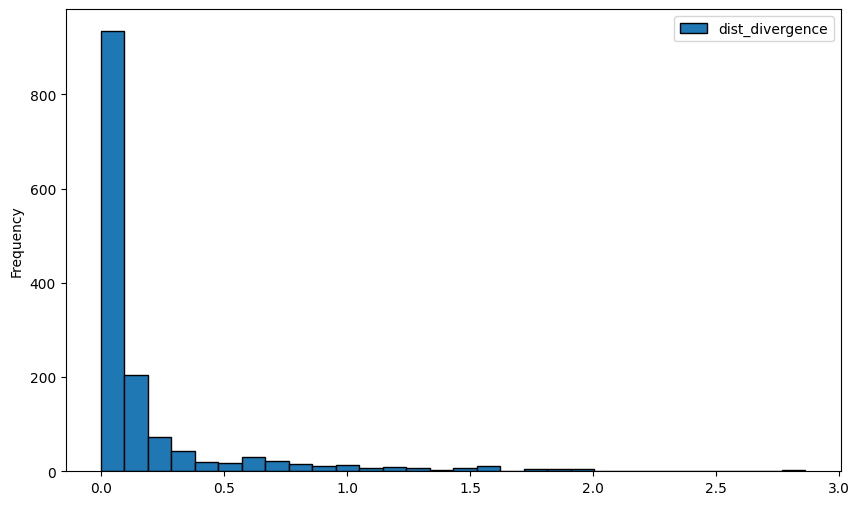

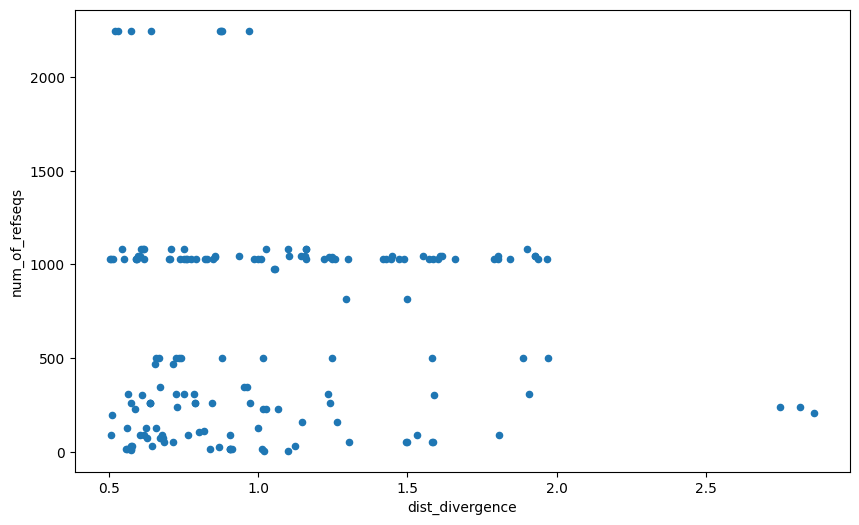

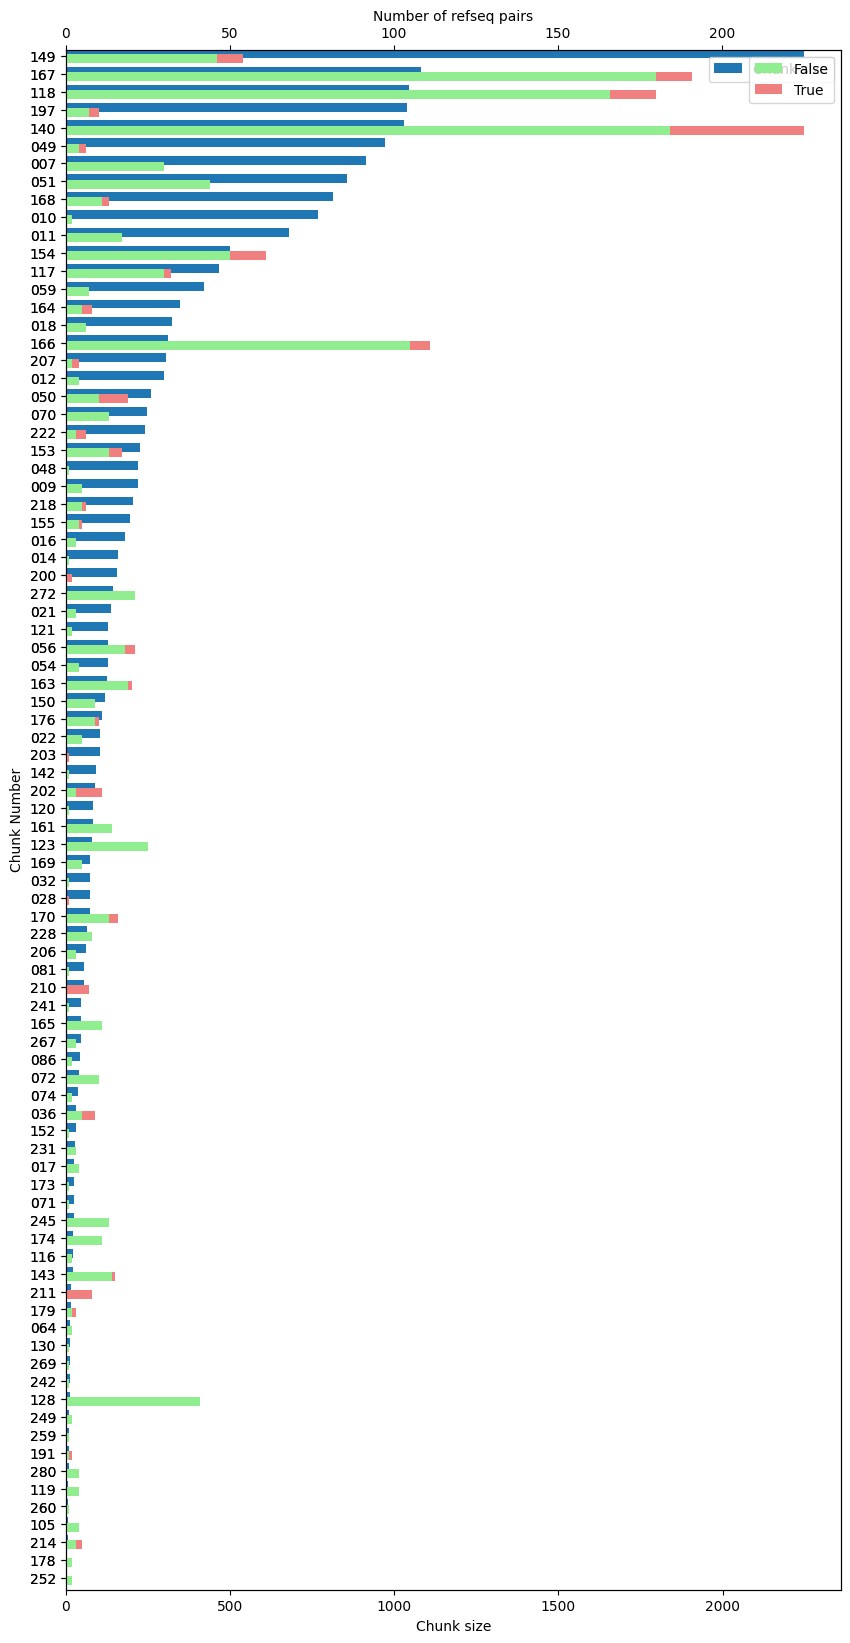

In [110]:
df_place_diff.plot.hist(column=["dist_divergence"], bins=30, edgecolor = "black", figsize=(10,6))
plt.show()

df_place_diff[df_place_diff["dist_divergence"] > 0.5].plot.scatter(x="dist_divergence", y="num_of_refseqs", figsize=(10,6))
plt.show()

chunk_sizes = df_place_diff.groupby(by="chunk_num")["num_of_refseqs"].first()
chunk_placements = (df_place_diff["dist_divergence"] > 0.5).groupby(by="chunk_num").value_counts().unstack(fill_value=0).rename(columns={True: "True", False: "False"})

chunk_summary = chunk_placements.join(chunk_sizes).sort_values(by="num_of_refseqs")

fig, ax1 = plt.subplots(figsize=(10,20))
ax2 = ax1.twiny()

chunk_summary["num_of_refseqs"].plot.barh(ax=ax1, position=0.2, width=0.5, label="Chunk size")
chunk_summary[["False", "True"]].plot.barh(stacked=True, ax=ax2, position=0.8, width=0.5, color=['lightgreen', 'lightcoral'], label="Number of refseq pairs")

ax1.set_xlabel('Chunk size')
ax2.set_xlabel('Number of refseq pairs')
ax1.set_ylabel('Chunk Number')
ax2.set_ylabel('')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.show()
